# Importing libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
import keras
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import (
    Input, Conv2D, 
    Flatten, Dense, Dropout, AveragePooling2D
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import MaxPool2D , concatenate , GlobalAveragePooling2D , Dense , Dropout

# Step 1: Loading the flowers datasets

## Loading flowers dataset

In [2]:
# Function to load and preprocess images
def load_and_preprocess_data(folder_path, image_size=(224, 224)):
    image_data = []
    labels = []

    # Use tqdm for progress tracking in the first loop only
    for flower_type in tqdm(os.listdir(folder_path), desc="Loading and Preprocessing"):
        flower_folder = os.path.join(folder_path, flower_type)

        if os.path.isdir(flower_folder):
            for filename in os.listdir(flower_folder):
                image_path = os.path.join(flower_folder, filename)

                # Read and resize the image
                img = Image.open(image_path)
                img = img.resize(image_size)
                img_array = np.array(img)

                # Append the image data and label
                image_data.append(img_array)
                labels.append(flower_type)

    # Convert the lists to numpy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels

# Set the path to the flowers folder
folder_path = '/kaggle/input/flowers-recognition/flowers'

# Load and preprocess the data
image_data, labels = load_and_preprocess_data(folder_path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets with stratification
x_train, x_test, y_train, y_test = train_test_split(
    image_data, encoded_labels, test_size=0.2, random_state=42, stratify=labels
)

Loading and Preprocessing: 100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


## checking shapes

In [23]:
print('\n------------------------------------------------\n')
print(f'X Train of flowers {x_train.shape}')
print(f'y Train of flowers {y_train.shape}')
print('\n')
print(f'X Test of flowers {x_test.shape}')
print(f'y Test of flowers {y_test.shape}')
print('\n------------------------------------------------\n')


------------------------------------------------

X Train of flowers (3453, 224, 224, 3)
y Train of flowers (3453,)


X Test of flowers (864, 224, 224, 3)
y Test of flowers (864,)

------------------------------------------------



In [4]:
print(f'Classes/Categories of y train we want our model to predict in flowers dataset {np.unique(y_train)}')

Classes/Categories of y train we want our model to predict in flowers dataset [0 1 2 3 4]


## visualizing our labels

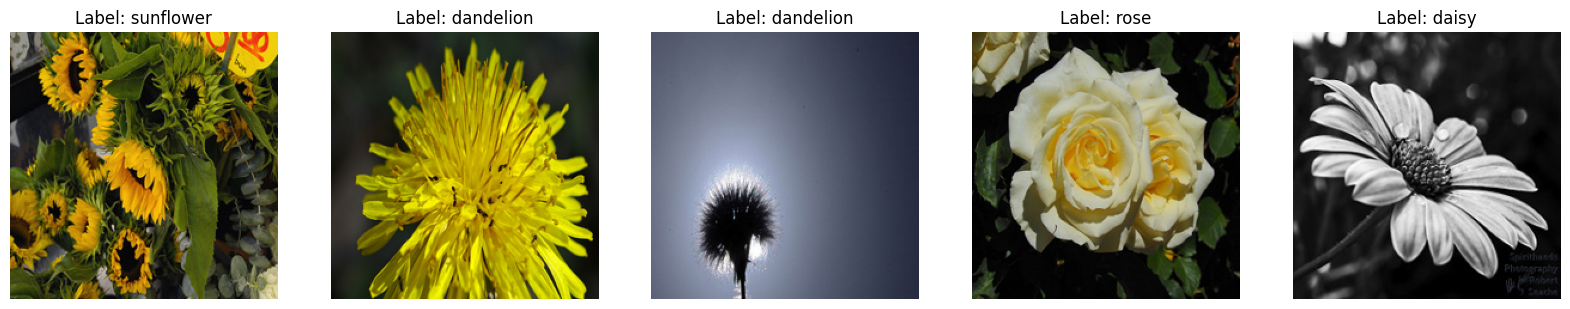

In [5]:
# Visualize a few sample images with a larger figure size
num_samples_to_visualize = 5

plt.figure(figsize=(20, 8))  # Adjust the figsize to make it larger

for i in range(num_samples_to_visualize):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.imshow(x_train[i], cmap='gray')

    # Decode the label
    original_label = label_encoder.inverse_transform([y_train[i]])[0]

    plt.title(f"Label: {original_label}")
    plt.axis('off')

plt.show()

# Step 2: Pre-processing

In [6]:
# Normalize the pixel values to be in the range [0, 1] for both datasets
x_train_flowers, x_test_flowers = x_train / 255.0, x_test / 255.0

In [7]:
# input shape and number of classes
input_shape = (224, 224, 3)

num_classes = 5

# Step 3: building the Model

## `Model Layers`

#### `Input Layer`: Accepts input images with dimensions (224, 224, 3).

#### `Convolutional Layers`: Several convolutional layers with varying filter sizes and strides for feature extraction.

#### `Pooling Layers`: Max pooling layers to downsample the spatial dimensions.

#### `Inception Modules`: Multiple instances of inception modules with different filter configurations.

#### `Auxiliary Output Branches`: Additional branches with their own convolutional and fully connected layers for auxiliary classification.

#### `Global Average Pooling`: Reduces the spatial dimensions to a single vector by taking the average of each feature map.

#### `Dropout Layers`: Regularization technique to prevent overfitting.

#### `Fully Connected Layers`: Dense layers for final classification.

## Inception Model from scratch

In [3]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
    
    return output

In [4]:
def Inception_Model_Scartch(input_shape, num_classes):
    
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

    x = inception_module(x,
                        filters_1x1=64,
                        filters_3x3_reduce=96,
                        filters_3x3=128,
                        filters_5x5_reduce=16,
                        filters_5x5=32,
                        filters_pool_proj=32)

    x = inception_module(x,
                        filters_1x1=128,
                        filters_3x3_reduce=128,
                        filters_3x3=192,
                        filters_5x5_reduce=32,
                        filters_5x5=96,
                        filters_pool_proj=64)

    x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

    x = inception_module(x,
                        filters_1x1=192,
                        filters_3x3_reduce=96,
                        filters_3x3=208,
                        filters_5x5_reduce=16,
                        filters_5x5=48,
                        filters_pool_proj=64)


    x1 = AveragePooling2D((5, 5), strides=3)(x)
    x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation='relu')(x1)
    x1 = Dropout(0.7)(x1)
    x1 = Dense(10, activation='softmax')(x1)

    x = inception_module(x,
                        filters_1x1=160,
                        filters_3x3_reduce=112,
                        filters_3x3=224,
                        filters_5x5_reduce=24,
                        filters_5x5=64,
                        filters_pool_proj=64)

    x = inception_module(x,
                        filters_1x1=128,
                        filters_3x3_reduce=128,
                        filters_3x3=256,
                        filters_5x5_reduce=24,
                        filters_5x5=64,
                        filters_pool_proj=64)

    x = inception_module(x,
                        filters_1x1=112,
                        filters_3x3_reduce=144,
                        filters_3x3=288,
                        filters_5x5_reduce=32,
                        filters_5x5=64,
                        filters_pool_proj=64)


    x2 = AveragePooling2D((5, 5), strides=3)(x)
    x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation='relu')(x2)
    x2 = Dropout(0.7)(x2)
    x2 = Dense(10, activation='softmax')(x2)

    x = inception_module(x,
                        filters_1x1=256,
                        filters_3x3_reduce=160,
                        filters_3x3=320,
                        filters_5x5_reduce=32,
                        filters_5x5=128,
                        filters_pool_proj=128)

    x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

    x = inception_module(x,
                        filters_1x1=256,
                        filters_3x3_reduce=160,
                        filters_3x3=320,
                        filters_5x5_reduce=32,
                        filters_5x5=128,
                        filters_pool_proj=128)

    x = inception_module(x,
                        filters_1x1=384,
                        filters_3x3_reduce=192,
                        filters_3x3=384,
                        filters_5x5_reduce=48,
                        filters_5x5=128,
                        filters_pool_proj=128)

    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.4)(x)

    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=[x, x1, x2])


In [26]:
# Initialize kernel and bias initializers
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

# Create Inception model for flowers dataset
inception_model_scratch = Inception_Model_Scartch(input_shape, num_classes)

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


### Printing Inception architecture

In [27]:
inception_model_scratch.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 56, 56, 64)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv_2a_3x3/1 (Conv2D)      (None, 56, 56, 64)           4160      ['max_pool_1_3x3/2[0][0]

In [28]:
# Compile the flowers model
inception_model_scratch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception_model_scratch_history = inception_model_scratch.fit(x_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 66s 3s/step - loss: 10.0889 - output_loss: 3.2388 - auxilliary_output_1_loss: 4.1900 - auxilliary_output_2_loss: 2.6601 - output_accuracy: 0.2017 - auxilliary_output_1_accuracy: 0.2136 - auxilliary_output_2_accuracy: 0.1988 - val_loss: 4.8515 - val_output_loss: 1.6301 - val_auxilliary_output_1_loss: 1.5897 - val_auxilliary_output_2_loss: 1.6317 - val_output_accuracy: 0.1708 - val_auxilliary_output_1_accuracy: 0.3401 - val_auxilliary_output_2_accuracy: 0.2402
Epoch 2/100
11/11 [==============================] - 9s 830ms/step - loss: 4.8077 - output_loss: 1.6348 - auxilliary_output_1_loss: 1.5204 - auxilliary_output_2_loss: 1.6525 - output_accuracy: 0.2335 - auxilliary_output_1_accuracy: 0.3736 - auxilliary_output_2_accuracy: 0.2458 - val_loss: 4.2341 - val_output_loss: 1.5300 - val_auxilliary_output_1_loss: 1.2883 - val_auxilliary_output_2_loss: 1.4158 - val_output_accuracy: 0.3821 - val_auxilliary_output_1_accuracy: 0.4602 - val_auxi

### Printing the learning curve of flowers Dataset to avoid overfitting

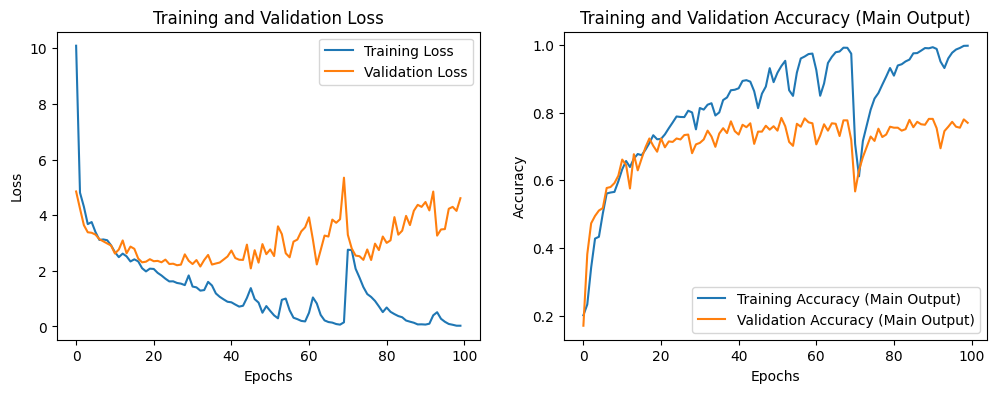

In [29]:
# Access the training history
loss = inception_model_scratch_history.history['loss']
val_loss = inception_model_scratch_history.history['val_loss']
output_accuracy = inception_model_scratch_history.history['output_accuracy']
val_output_accuracy = inception_model_scratch_history.history['val_output_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy for the main output
plt.subplot(1, 2, 2)
plt.plot(output_accuracy, label='Training Accuracy (Main Output)')
plt.plot(val_output_accuracy, label='Validation Accuracy (Main Output)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Main Output)')
plt.legend()
plt.show()


### Predicting the test set

In [30]:
# Make predictions on the test set
y_pred_list = inception_model_scratch.predict(x_test)

27/27 [==============================] - 3s 31ms/step


In [31]:
# Extract the main output predictions
y_pred_main = y_pred_list[0]

In [32]:
# Obtain argmax for the main output
y_pred_main_argmax = np.argmax(y_pred_main, axis=1)

### Confusion Matrix for the model

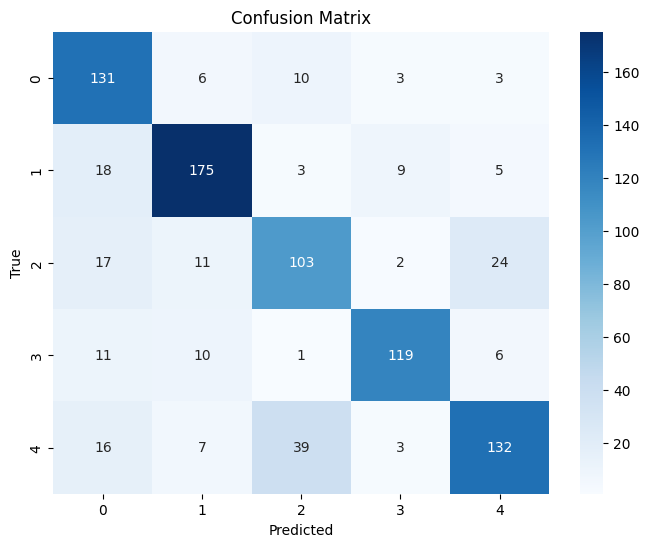

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_main_argmax)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_main_argmax, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.7655608098676643
Recall: 0.7650336020038544
F1 Score: 0.7622060084851814


#### `Insufficient Data`: The model might not have been provided with enough diverse and representative training data. A larger and more diverse dataset could improve the model's ability to generalize to new, unseen examples.

#### `Complexity of the Model`: The Inception model is a relatively complex architecture, and training it may require careful tuning of hyperparameters. If the model is too large or too deep for the given dataset, it might suffer from overfitting, especially if the dataset is small.

#### `Overfitting`: The model might be overfitting to the training data, capturing noise or specific patterns that do not generalize well to new data. Regularization techniques like dropout or weight decay can be applied to mitigate overfitting.

#### `Hyperparameter Tuning`: The choice of hyperparameters, such as learning rate, batch size, and the number of epochs, can significantly impact the training process. Fine-tuning these hyperparameters through experimentation may improve model performance.

## Inception Model built in

In [8]:
def Inception_Model_Builtin(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    inception_model = Model(inputs=base_model.input, outputs=predictions)
    inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    inception_model.summary()
    return inception_model

In [10]:
# Create Inception model for flowers dataset
inception_model_builtin = Inception_Model_Builtin(input_shape, num_classes)

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

### Printing Inception architecture

In [17]:
# Fit the model on the training data
inception_model_builtin_history = inception_model_builtin.fit(x_train, 
                                                              y_train, 
                                                              epochs=100, 
                                                              batch_size=256, 
                                                              validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 7s 616ms/step - loss: 1.3991 - accuracy: 0.3910 - val_loss: 1.4461 - val_accuracy: 0.3893
Epoch 2/100
11/11 [==============================] - 7s 608ms/step - loss: 1.4080 - accuracy: 0.3921 - val_loss: 1.4512 - val_accuracy: 0.4023
Epoch 3/100
11/11 [==============================] - 7s 624ms/step - loss: 1.3876 - accuracy: 0.4041 - val_loss: 1.4391 - val_accuracy: 0.4226
Epoch 4/100
11/11 [==============================] - 7s 642ms/step - loss: 1.3670 - accuracy: 0.4254 - val_loss: 1.4442 - val_accuracy: 0.4110
Epoch 5/100
11/11 [==============================] - 7s 653ms/step - loss: 1.3522 - accuracy: 0.4294 - val_loss: 1.4176 - val_accuracy: 0.4197
Epoch 6/100
11/11 [==============================] - 7s 639ms/step - loss: 1.3414 - accuracy: 0.4298 - val_loss: 1.4279 - val_accuracy: 0.4081
Epoch 7/100
11/11 [==============================] - 7s 625ms/step - loss: 1.3256 - accuracy: 0.4290 - val_loss: 1.4127 - val_accuracy: 0.4168

### Printing the learning curve of flowers Dataset to avoid overfitting

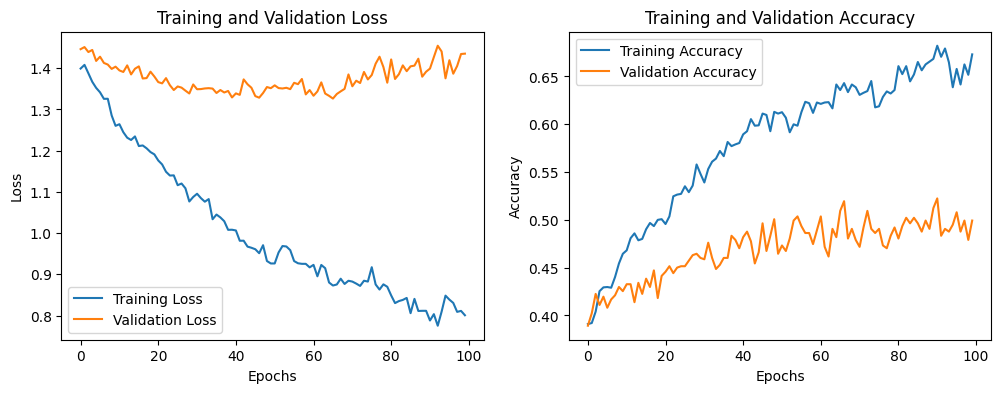

In [18]:
# Access the training history
loss = inception_model_builtin_history.history['loss']
val_loss = inception_model_builtin_history.history['val_loss']
accuracy = inception_model_builtin_history.history['accuracy']
val_accuracy = inception_model_builtin_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Predicting the test set

In [19]:
# Make predictions on the test set
y_pred = inception_model_builtin.predict(x_test)

27/27 [==============================] - 2s 62ms/step


In [20]:
# Convert to class labels
y_pred = np.argmax(y_pred, axis=1)

### Confusion Matrix for the model

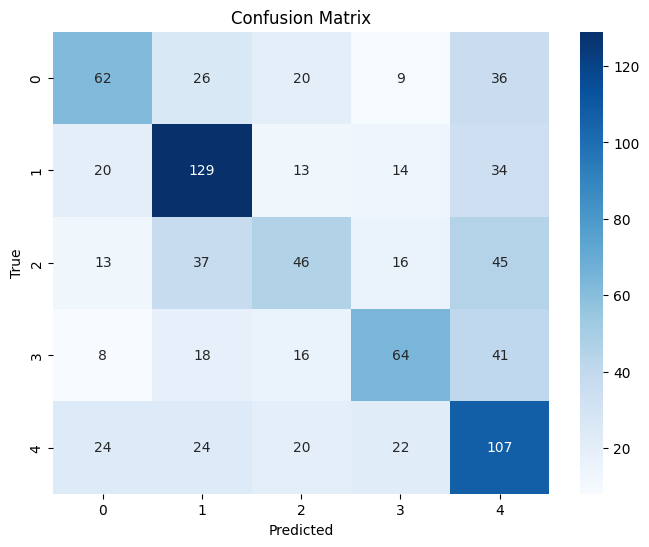

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [22]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.47166302682477645
Recall: 0.45820589216211777
F1 Score: 0.45959582893086726


#### `Image Resolution`: InceptionV3 expects input images with a shape of (299, 299, 3). That's why the model performs bad with our data as its shape is (224, 224, 3).